# Statistical Arbitrage on SPX Technology Sector

In this piece, we perform a statistical arbitrage technique to the technology sector of the S&P 500 Index.
The work that follows aims to identify cointegrated and correlated equity pairs, for which 
statistical arbitrage opportunities emerge based on the mean-reversion property. More specifically, if two assets are cointegrated then, there exists a constant $b$ such that their linear combination i.e the cointegration residual,  will be a stationary, zero-mean reverting process. Therefore, if the prices of the two assets diverge temporarily, then they will eventually converge to their short-term  statistical equilibrium. The process yields arbitrage opportunities by generating long/short trading signals with the following setup:

* Short 1 unit of asset Y and long b units of asset X, whenever the cointegration 
residual exceeds a given threshold.
*  Long 1 unit of asset Y and short b units of asset X whenever the cointegration 
residual is less than a given threshold.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split


### Extract sample tickers from the tech sector and download daily sample data from 09/2021 to 09/2022:

In [2]:

list_tickers = [
    'AAPL', 'CSCO', 'CRM', 'TSM', 'QCOM', 'DELL', 'HPQ', 'HPE', 'ON', 'ADI',
    'MU', 'MRVL', 'MCHP', 'UBER', 'SHOP', 'AMD', 'INTC', 'NVDA', 'MSFT', 'ORCL'
]

start = datetime.datetime(2021, 9, 15)
end = datetime.datetime(2022, 9, 16)

df = yf.download(
    list_tickers,
    start=start,
    end=end,
    progress=False,
    group_by='ticker'
)


Adjusted Closing Prices:

In [3]:

# Create an empty DataFrame to store required columns
df_adjcloseall = pd.DataFrame()

# Get adjusted closing price for tickers
for i in range(len(list_tickers)):
    
    df_adjclose = df[list_tickers[i]]['Adj Close']
    df_adjclose = pd.DataFrame(data = df_adjclose)
    df_adjclose.rename(columns = {'Adj Close': list_tickers[i]}, inplace=True)
    df_adjcloseall = pd.concat([df_adjcloseall, df_adjclose], axis = 1)

df_adjcloseall.head()


,AAPL,CSCO,CRM,TSM,QCOM,DELL,HPQ,HPE,ON,ADI,MU,MRVL,MCHP,UBER,SHOP,AMD,INTC,NVDA,MSFT,ORCL
Date,,,,,,,,,,,,,,,,,,,,
2021-09-15,147.325546,53.785110,256.160004,116.254570,132.130142,48.523968,26.192398,12.905798,49.209999,167.799850,72.667862,61.812374,78.422935,38.480000,147.494003,105.599998,51.618008,223.094620,299.395935,84.958626
2021-09-16,147.088303,53.570194,260.359985,116.049934,132.283051,48.987755,26.276741,12.830655,49.400002,166.961258,73.465202,62.594185,78.867798,39.520000,147.597000,106.220001,51.346432,222.105988,299.788818,84.493790
2021-09-17,144.389526,53.121670,260.529999,113.129234,127.695236,48.567444,25.939377,12.727334,48.889999,165.332230,73.140373,61.456100,77.895897,39.750000,148.628998,103.879997,50.812637,218.690826,294.533997,83.660950
2021-09-20,141.305222,52.224632,258.220001,110.198921,126.892342,48.731705,25.527046,12.473726,47.669998,163.365814,71.240486,60.050831,75.676514,39.790001,143.453003,101.550003,49.613960,210.831940,289.063110,83.447899
2021-09-21,141.789612,51.635944,257.970001,110.448700,125.926979,47.992538,25.142826,12.220118,47.680000,164.416504,71.014084,60.397198,76.053665,44.360001,143.714996,102.820000,49.510956,212.160049,289.554230,84.174210


 Visualize the correlations:

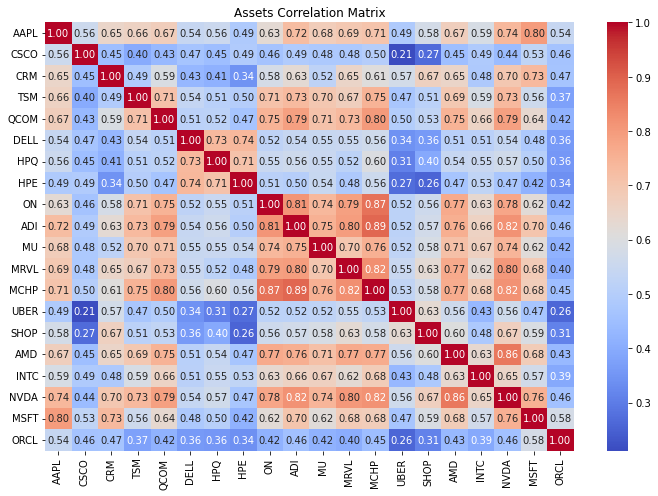

In [4]:

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_adjcloseall.pct_change().corr(method = 'pearson'), 
            ax = ax, cmap='coolwarm', annot=True, fmt=".2f")

ax.set_title('Assets Correlation Matrix')
plt.tight_layout()
plt.show()


### Identify Co-integrated equity pairs:

Function to find cointegrated equity pairs within the equity universe using the Engle-Granger test at  5% statistical significance level.

The hypothesis testing setup for the Engle-Granger test is:

* Ho: No Co-integration exists between the two series
* Ha: The series is co-integrated

Thus, for equity pairs with p-values< 5% there exists evidence in support of co-integration existence

In [5]:

def find_cointegrated_pairs(data):
    
    n = data.shape[1]
    
    # Allocate matrix to store the p-values
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    
    # Empty list to store the extracted pairs
    pairs = []
    
    for i in range(n):
        
        for j in range(i+1, n):
            
            # Using the coint Engle-Granger to calculate co-integrated pairs
            result = coint(data[keys[i]], data[keys[j]]) 
            pvalue_matrix[i, j] = result[1]
            
            # The pair is cointegrated if:
            if result[1] < 0.05:
                
                pairs.append((keys[i], keys[j]))
                
    return pvalue_matrix, pairs


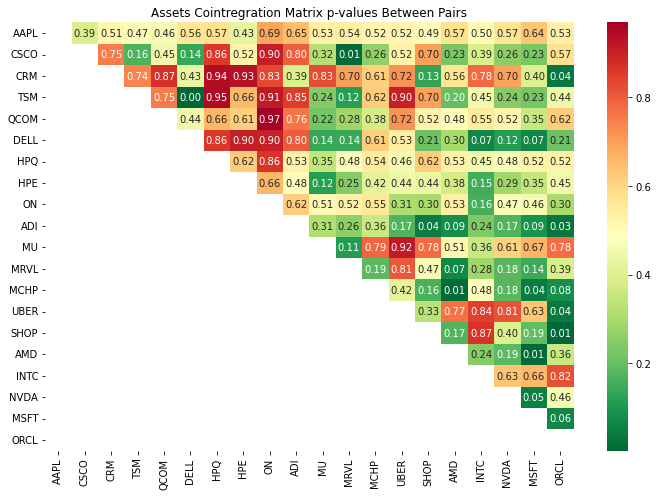

In [6]:

# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(df_adjcloseall)

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(pvalues, xticklabels = df_adjcloseall.columns,
                yticklabels = df_adjcloseall.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()

### Extract the tickers of the co-integrated pairs:

In [7]:

import itertools

#Collapse the list of tuples into a list of unique elements:
tickers = set(itertools.chain(*pairs))
print("The Co-integrated pairs are:")

for pair in pairs:
    print(pair)

The Co-integrated pairs are:
('CSCO', 'MRVL')
('CRM', 'ORCL')
('TSM', 'DELL')
('ADI', 'SHOP')
('ADI', 'ORCL')
('MCHP', 'AMD')
('MCHP', 'MSFT')
('UBER', 'ORCL')
('SHOP', 'ORCL')
('AMD', 'MSFT')


In [8]:
# Create empty dataframe to store the cointegrated stocks time series data
cointegratedstocks = pd.DataFrame()

# Get adjusted closing price for tickers
for ticker in tickers:
    df_adjclose = df[ticker]['Adj Close']
    df_adjclose = pd.DataFrame(data = df_adjclose)
    df_adjclose.rename(columns = {'Adj Close':ticker}, inplace = True)
    cointegratedstocks = pd.concat([cointegratedstocks, df_adjclose], axis=1)
    

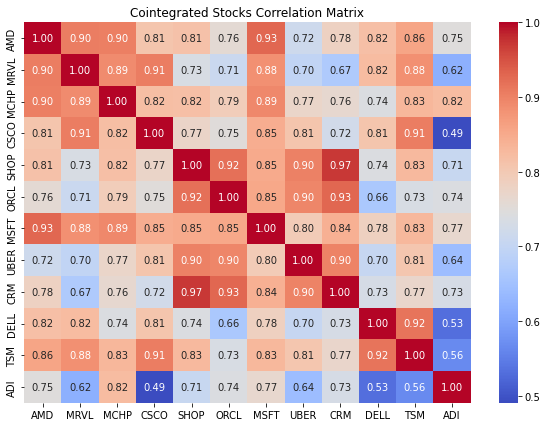

In [9]:
# Visualize the correlations between the co-integrated pairs:
fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(cointegratedstocks.corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Cointegrated Stocks Correlation Matrix')
plt.show()


### Extract the correlations of the co-integrated pairs:

In [10]:

correlation_matrix = cointegratedstocks.corr()

#Dict comprehension to extract the pairs and the corresponding values
correlations = {pair : correlation_matrix.loc[pair[0], pair[1]] for pair in pairs}

# Sort the correlations dictionary into descending order:
final_pairs = dict(sorted(correlations.items(), key = lambda x : x[1], reverse = True))

print("\nThe co-integrated pairs and the corresponding correlations are:")

for value in final_pairs.items():
    
    print(value)


The co-integrated pairs and the corresponding correlations are:
(('CRM', 'ORCL'), 0.9289114939907928)
(('AMD', 'MSFT'), 0.9283566466805224)
(('SHOP', 'ORCL'), 0.9197668751819372)
(('TSM', 'DELL'), 0.916367486940777)
(('CSCO', 'MRVL'), 0.9056097618970033)
(('MCHP', 'AMD'), 0.9033246461546776)
(('UBER', 'ORCL'), 0.8957571109314642)
(('MCHP', 'MSFT'), 0.8928074870425773)
(('ADI', 'ORCL'), 0.7401578245660128)
(('ADI', 'SHOP'), 0.7065691079494413)


### Apply the technique to the 5 highest correlated pairs:

In [11]:

y_stocks = [value[0] for value in list(final_pairs.keys())[ :5]]
x_stocks=[value[1] for value in list(final_pairs.keys())[ :5]]

print(y_stocks,x_stocks)

['CRM', 'AMD', 'SHOP', 'TSM', 'CSCO'] ['ORCL', 'MSFT', 'ORCL', 'DELL', 'MRVL']


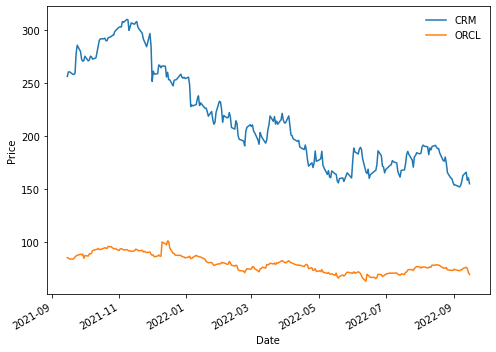

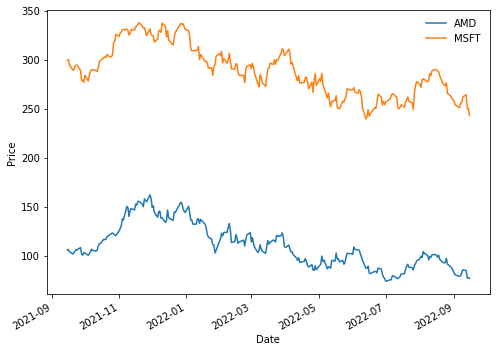

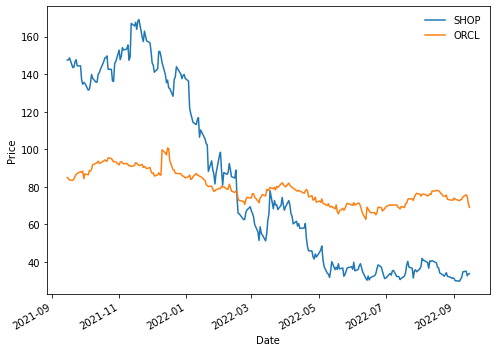

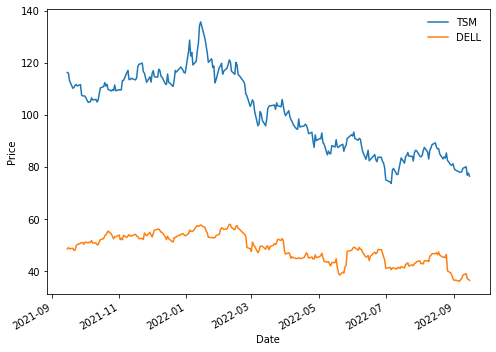

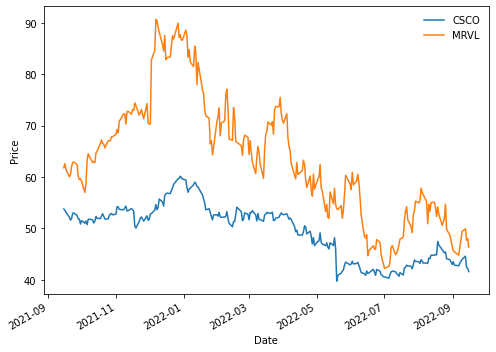

In [12]:

for value in list(final_pairs.keys())[ :5]:
    
    cointegratedstocks.plot(y = list(value), figsize = (7,5))
    plt.ylabel("Price")
    plt.tight_layout()
    plt.legend(frameon=False)
    plt.show()
    

### Split the data into train and test 80-20:

In [13]:
# Define the stock symbols
stocks = ['CSCO', 'MRVL', 'TSM', 'DELL', 'CRM', 'ORCL', 'AMD', 'SHOP', 'MSFT']

# Create empty dictionaries to store the train and test data
train_data = {}
test_data = {}

# Loop through each stock and split the data
for stock in stocks:
    stock_data = np.array(cointegratedstocks[stock])
    train_data[stock], test_data[stock] = train_test_split(stock_data, test_size=0.2, shuffle=False)
    
    # Reshape the results into 2-D arrays
    train_data[stock] = train_data[stock].reshape((-1, 1))
    test_data[stock] = test_data[stock].reshape((-1, 1))

#Collect the train and test data into dataframes:
y_train=pd.DataFrame()
x_train=pd.DataFrame()
y_test=pd.DataFrame()
x_test=pd.DataFrame()

for stock in y_stocks:
    
    y_train = pd.concat([y_train, pd.DataFrame(train_data[stock], columns = [stock])], axis = 1)
    y_test = pd.concat([y_test, pd.DataFrame(test_data[stock], columns = [stock])], axis = 1)
    
for stock in x_stocks:
    
    x_train = pd.concat([x_train, pd.DataFrame(train_data[stock], columns = [stock])], axis = 1)
    x_test = pd.concat([x_test, pd.DataFrame(test_data[stock], columns = [stock])], axis = 1)
    

### Run frequentist OLS regressions to the train data to extract the co-integration constant beta:

In [14]:

pairs_analyzed=list(final_pairs.keys())[:5]

a = []
b = []

for i in range(x_train.shape[1]):
    
    y = y_train.iloc[:, i]
    
    # Define the model matrix
    x = x_train.iloc[:, i] 
    x=sm.add_constant(x)
    
    # Fit the linear model
    model_fit=sm.OLS(y,x).fit()
    
    #Collect the constant and the beta:
    a.append(model_fit.params[0])
    b.append(model_fit.params[1])
    
print(f"\nThe normalizing constants are: {a} \n \n and the betas are: {b}")


The normalizing constants are: [-162.66115684481278, -110.05260917364453, -292.5556649337277, -24.891899354810796, 25.59951624637762] 
 
 and the betas are: [4.813984980945656, 0.7652460686567724, 4.770155250499195, 2.580904677498697, 0.38047279784895127]


In [15]:

# Compute the co-integration residuals:
spreads = pd.DataFrame()

for i in range(len(b)):
    
    spread = -a[i] + y_train.iloc[: , i] -b[i] * x_train.iloc[: , i]
    spreads = pd.concat([spreads, spread], axis=1)
    
spreads.columns=pairs_analyzed

# Assign DatetimeIndex to the spread:
spreads.index = pd.date_range(start=start, periods = y_train.shape[0], freq="B")
spreads.head()

,"(CRM, ORCL)","(AMD, MSFT)","(SHOP, ORCL)","(TSM, DELL)","(CSCO, MRVL)"
2021-09-15,9.831612,-13.458955,34.783833,15.910734,4.667667
2021-09-16,16.269308,-13.139604,37.104171,14.509108,4.155293
2021-09-17,20.448600,-11.458377,42.108944,12.673191,4.139779
2021-09-20,19.164226,-9.601797,37.949235,9.318936,3.777408
2021-09-21,15.417777,-8.707627,34.746613,11.476432,3.056937


### Visualize the co-integration residuals

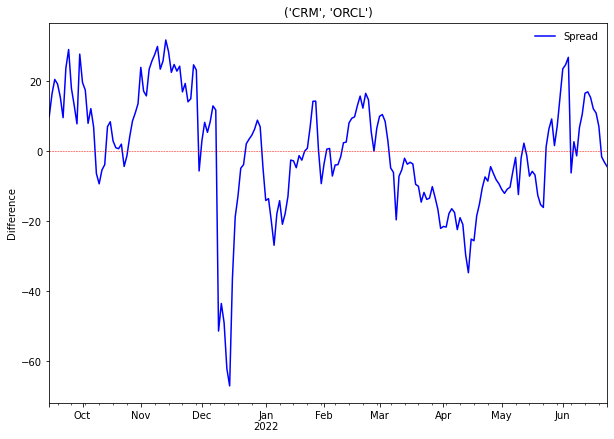

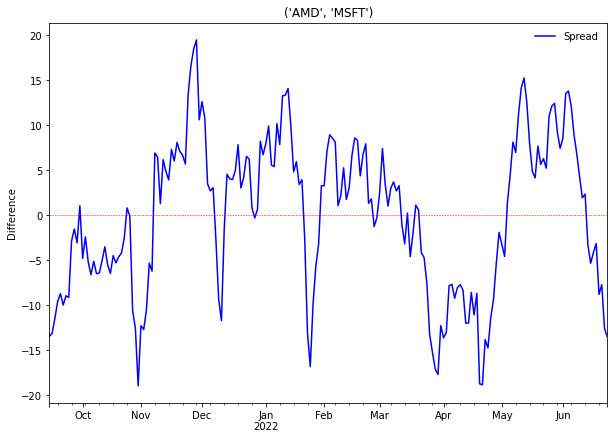

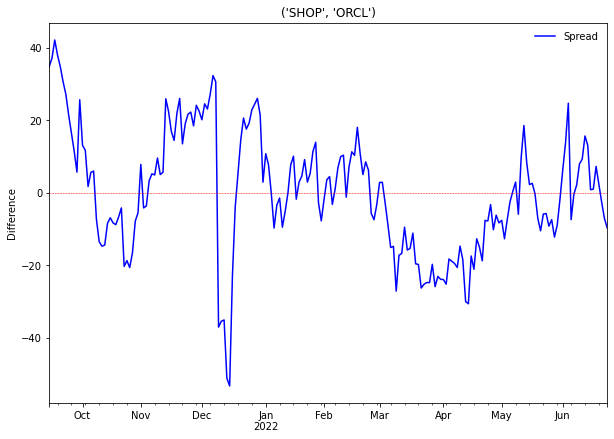

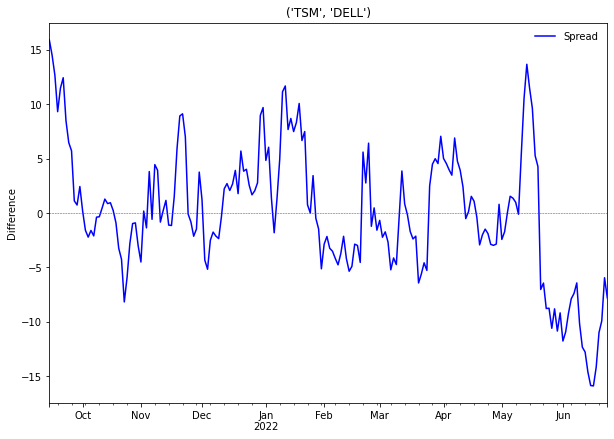

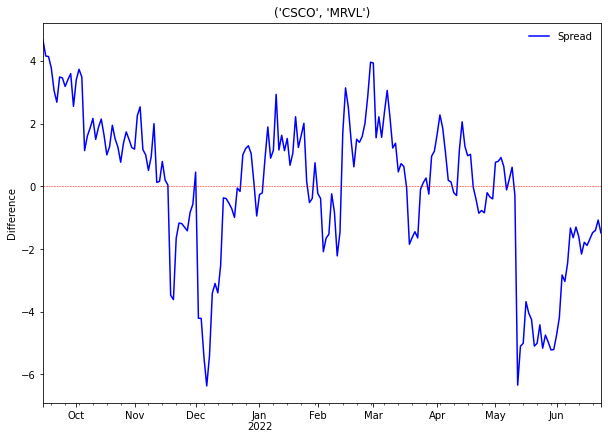

In [16]:

for column in spreads.columns:
    
    fig, ax = plt.subplots(figsize = (10,7))
    spreads[column].plot(ax = ax, label="Spread", color="blue")
    plt.axhline(y = 0, linewidth=0.5, linestyle = "--",color="r")
    ax.set_title(column)
    ax.legend(frameon=False)
    plt.ylabel("Difference")
    
plt.show()

### Apply Augmented Dickey-Fuller test to examine if the residuals are stationary:

Hypothesis testing setup for the ADF Test:

* $H_o$: There is a Unit Root, the series is non-stationary
* $H_1$: No Unit Root, the series is stationary

In [17]:

for i in range(spreads.shape[1]):
    
    result = adfuller(spreads.iloc[: , i], autolag='AIC')
    print(f"The ADF statistic is: {round(result[0], 2)} and the critical value at 5% level is:{round(result[4]['5%'], 2)}")
    

The ADF statistic is: -3.4 and the critical value at 5% level is:-2.88
The ADF statistic is: -3.34 and the critical value at 5% level is:-2.88
The ADF statistic is: -4.05 and the critical value at 5% level is:-2.88
The ADF statistic is: -4.0 and the critical value at 5% level is:-2.88
The ADF statistic is: -3.39 and the critical value at 5% level is:-2.88


### Trading signals generation:

$H_o$ is rejected for all the pairs. \
The co-integration residuals are stationary according to the ADF test and so they will revert to their statistical equilibrium level of $0$. \
\
We now proceed to generate the long-short trading signals to capitalize on the mean-reversion property. The signals will be generated using the test data in order to apply the strategy out-of-sample and eliminate overfitting biases. \
To generate the trading signals we compute the standardized Z ratio for each pair and then track the divergence from the statistical equilibrium.

The rationale for opening trades only when the Z-ratio is far from equilibrium is to trade only when we think
that we detected an anomalous excursion of the co-integration residual.
We then need to consider when we close trades. Closing trades when $Z_{ratio}=0$ also makes sense, since we expect most stocks
to be near equilibrium most of the time. Thus, our trading rule detects stocks with large ‘excursions’ and trades assuming these excursions will revert to the mean $0$ in a period of the order of the mean-reversion time.


#### Create the standardized residuals:


In [18]:

#Column-wise division by alligning the columns of two dataframes with different names based on their positions:
ratios = y_test.div(x_test.values)
means = ratios.mean(axis = 0)
stds = ratios.std(axis = 0)

# Standardized residuals
Z_ratios = (ratios - means) / stds
Z_ratios.columns=pairs_analyzed

#Create DatetimeIndex:
index = pd.date_range(start = spreads.index[-1] + timedelta(days = 1),
                      periods = ratios.shape[0], freq="B")
Z_ratios.index=index

Z_ratios.head()

,"(CRM, ORCL)","(AMD, MSFT)","(SHOP, ORCL)","(TSM, DELL)","(CSCO, MRVL)"
2022-06-24,0.758034,-2.390477,-0.107351,-1.571985,1.558419
2022-06-27,1.121672,-1.742661,0.705470,-0.684695,0.690246
2022-06-28,0.993091,-1.690258,0.786399,-0.473073,0.616574
2022-06-29,0.869667,-1.979668,-0.410700,-0.845739,1.220942
2022-06-30,0.320579,-1.452021,-0.192775,-1.097613,0.941043


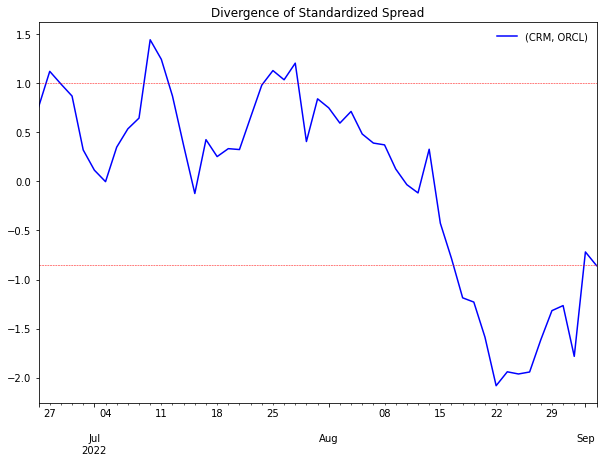

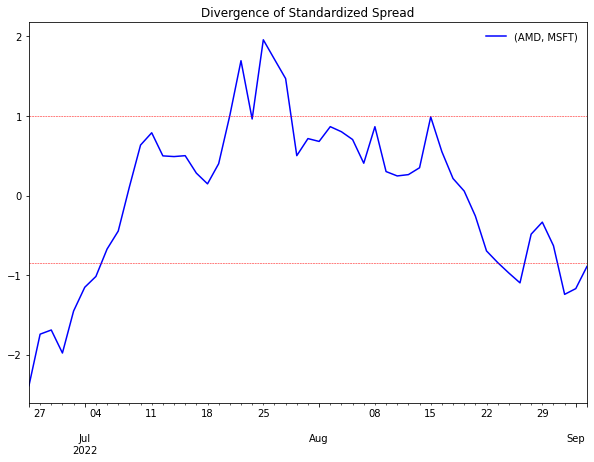

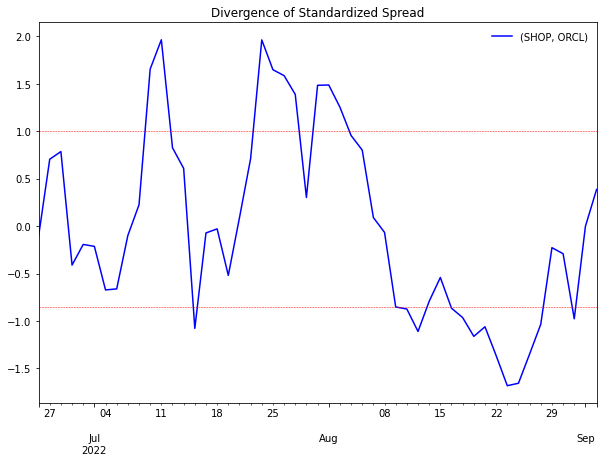

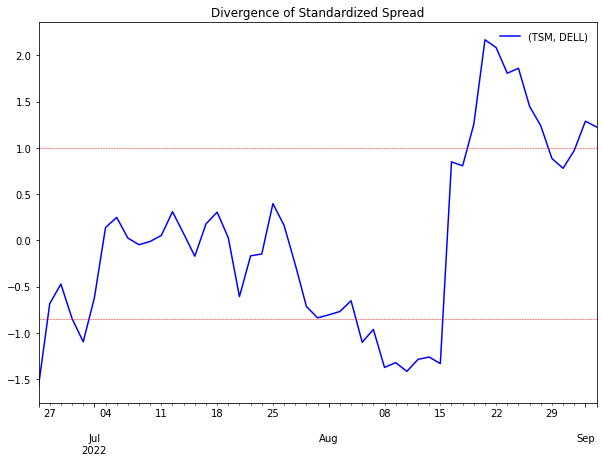

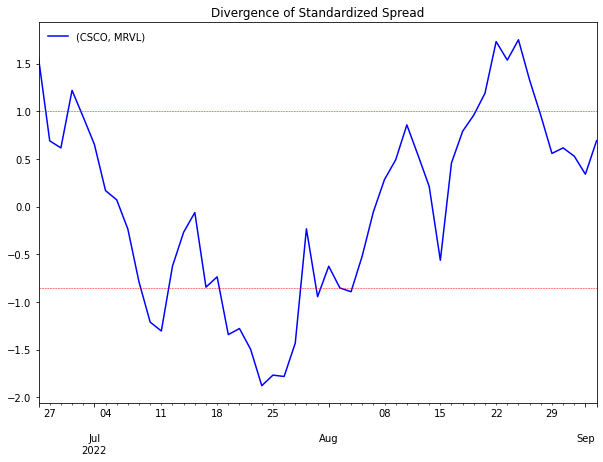

In [19]:

# Visualizing the standardized residuals
for column in Z_ratios.columns:
    
    fig, ax = plt.subplots(figsize = (10,7))
    Z_ratios[column].plot(ax = ax, color="blue", label=column)
    plt.axhline(y = -0.85, color="r", linestyle="--", linewidth=0.5)
    plt.axhline(y = 1, color="r",linestyle="--",linewidth=0.5)
    ax.set_title("Divergence of Standardized Spread")
    plt.legend(frameon=False)
    
plt.show()
    

### Rules for trading signals generation:

1. Long the pair: buy ($1*y$) and sell ($b*x$) whenever $Z<-1\sigma$
2. Short the pair: sell ($1*y$) and buy ($b*x$) whenever $Z>1\sigma$

In [20]:

# Allocate vector to store the trading signals
trading_signal = np.zeros(Z_ratios.shape)
Z = Z_ratios.values

# Excursion thresholds
U = 1
L = -0.85

# Tradings signals generation:
for j in range(Z.shape[1]):
    
    for i in range(Z.shape[0]):
        
        if Z[i, j] > U:
            
            # Short the pair
            trading_signal[i,j] = -1
            
        elif Z[i, j] < L:
            
            # Long the pair
            trading_signal[i, j] = + 1
            
# Collect the signals in a df        
trading_signal = pd.DataFrame(trading_signal, columns = pairs_analyzed, index = index)

# Compute the trading positions for each asset:
position_y = trading_signal.diff()
position_x = b * (-position_y)

### Visualizing the Trading Signals and the Position for each Traded Pair

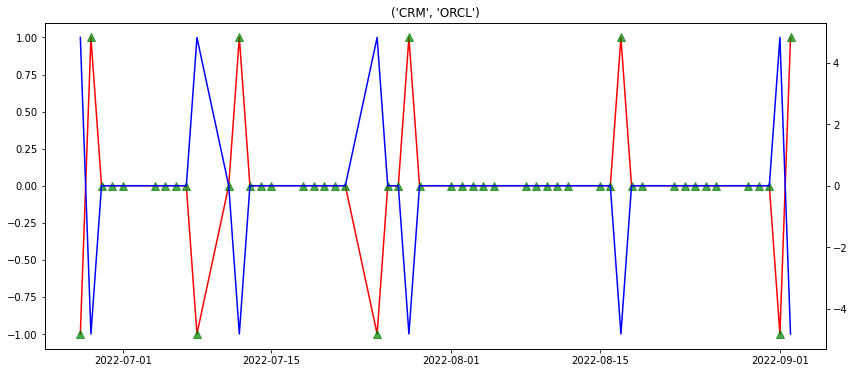

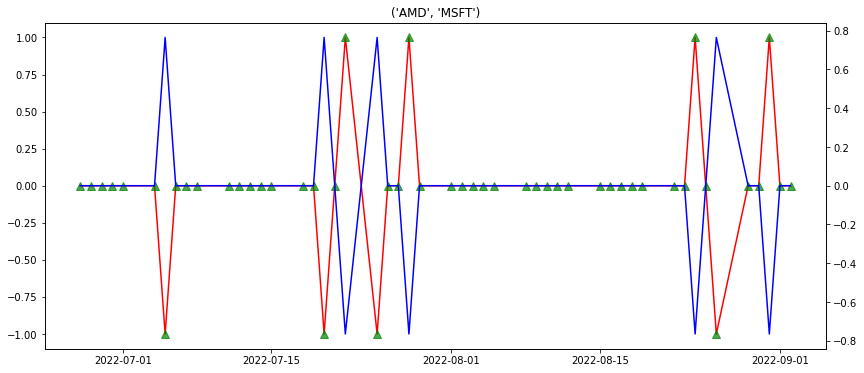

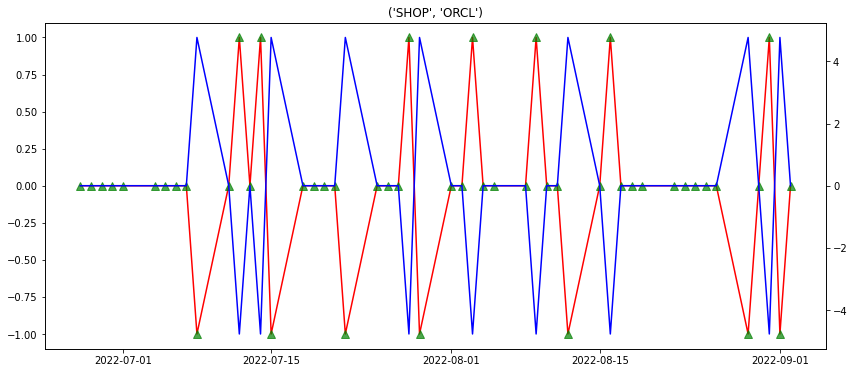

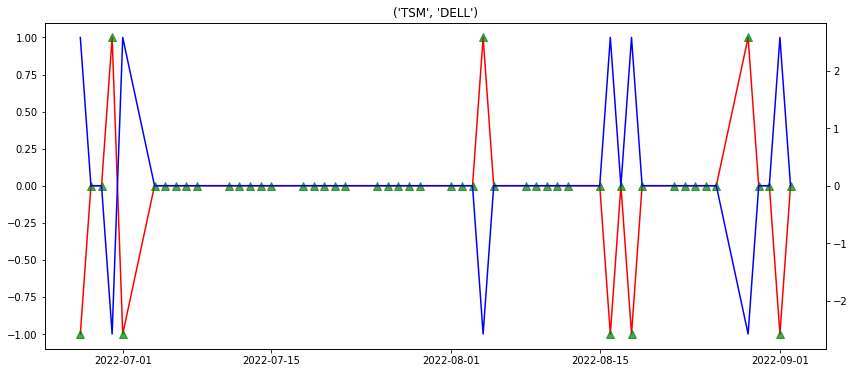

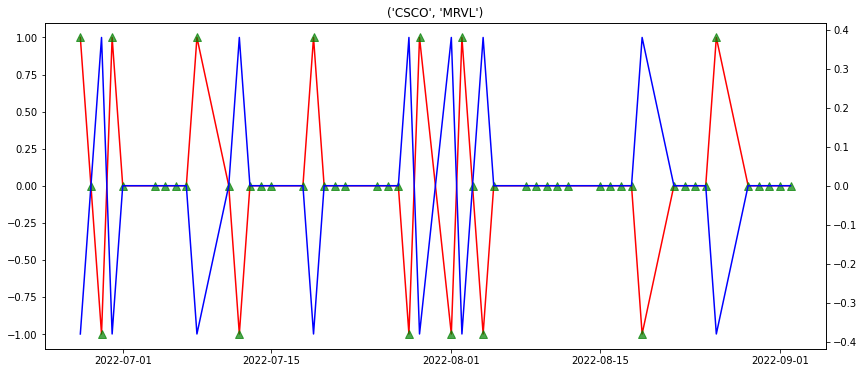

In [21]:

for column in trading_signal.columns:
    
    fig = plt.figure(figsize = (14, 6))
    bx = fig.add_subplot(111)   
    bx.set_title(column)
    bx2 = bx.twinx()
    
    l1, = bx.plot(position_y[column], c='r',label=column)
    l2, = bx2.plot(position_x[column], c='b')
    u1, = bx.plot(position_y[column], lw=0, marker='^', 
                  markersize=8, c='g',alpha=0.7,label="Trading Signal")
    
plt.show()

### Compute the number of shares to trade for each pair:

In [22]:

# Hypothetical initial cash value to invest:
cash = 10 ** 5

#Compute the Number of Shares to trade for each stock inside the Pairs
shares_y = np.zeros(len(y_stocks))
shares_x = np.zeros(len(x_stocks))

# Floor division
for i in range(len(y_stocks)):
    shares_y[i] = cash // max(cointegratedstocks[y_stocks[i]])
    shares_x[i] = cash // max(cointegratedstocks[x_stocks[i]])
    
print(shares_y)
print(shares_x)

[ 322.  617.  591.  736. 1661.]
[ 992.  296.  992. 1726. 1103.]


### Compute the performance of the arbitrage portfolios:

In [23]:

#Numerical value of the holdings of Asset Y at each time point untill expiry:
holdings_y = position_y.cumsum().mul((shares_y * y_test).values)

#Remaining cash after the trasnactions in Y
cash_y = cash + ((-1) * (position_y * shares_y).mul(y_test.values).cumsum())
total_asset_y = holdings_y + cash_y

#Numerical value of the holdings of Asset X at each time point untill expiry:
holdings_x = position_x.cumsum().mul((shares_x * x_test).values)
#Remaining cash after the trasnactions in X
cash_x = cash + ((-1) * (position_x * shares_x).mul(x_test.values).cumsum())
total_asset_x = holdings_x + cash_x

# Final portfolio values
final_portfolio = total_asset_x + total_asset_y
final_portfolio.head()

,"(CRM, ORCL)","(AMD, MSFT)","(SHOP, ORCL)","(TSM, DELL)","(CSCO, MRVL)"
2022-06-24,NaN,NaN,NaN,NaN,NaN
2022-06-27,200000.000000,200000.0,200000.0,200000.000000,200000.000000
2022-06-28,200554.131797,200000.0,200000.0,199297.691020,200108.833784
2022-06-29,200554.131797,200000.0,200000.0,199137.660472,200631.631140
2022-06-30,200554.131797,200000.0,200000.0,201582.073349,200631.631140


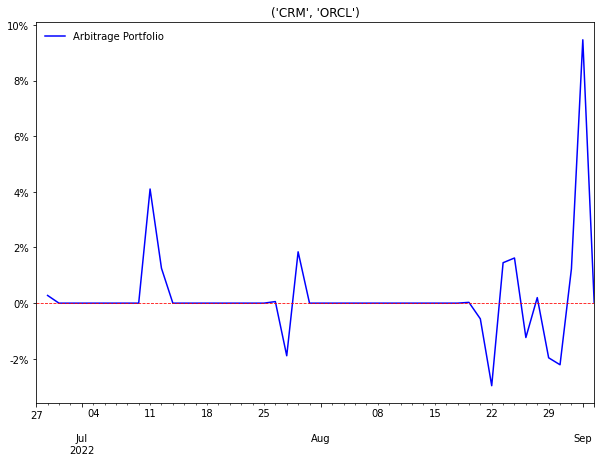

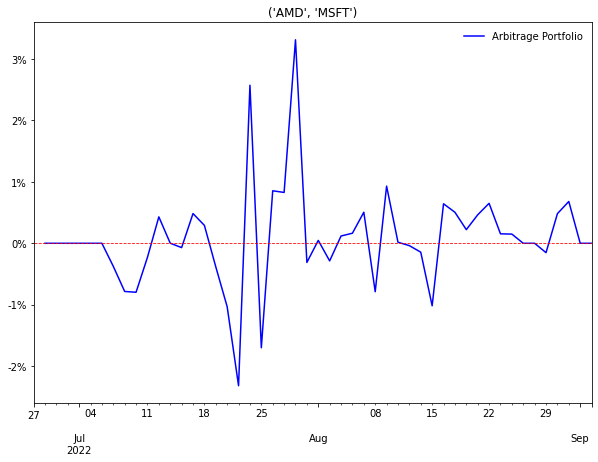

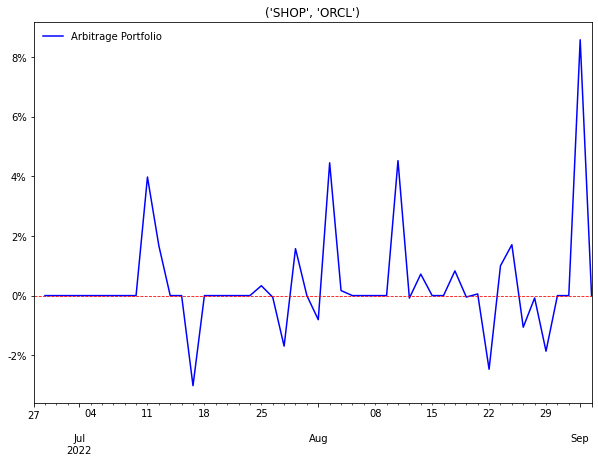

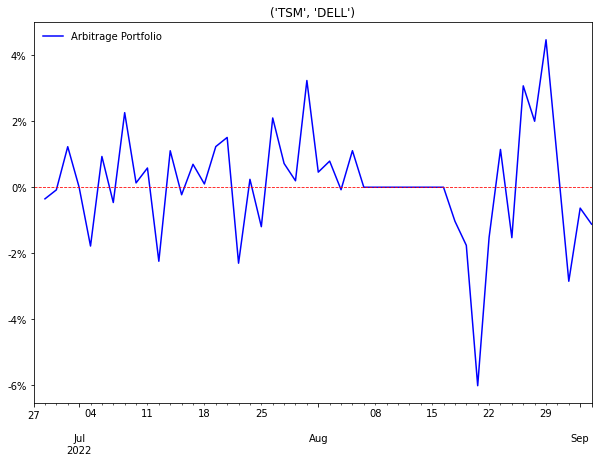

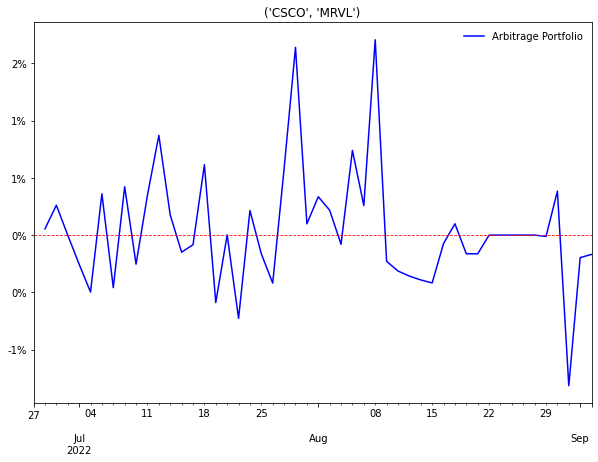

In [24]:

# Visualizing the arbitrage returns
arbitrage_returns = final_portfolio.dropna().pct_change()

for column in arbitrage_returns.columns:
    
    fig, ax = plt.subplots(figsize = (10, 7))
    arbitrage_returns[column].plot(ax = ax,color="blue", 
                                   label="Arbitrage Portfolio")
    
    labs = [str(round(100 * tick)) + "%" for tick in ax.get_yticks()]
    ax.set_yticklabels(labels = labs)
    ax.set_title(column)
    plt.axhline(y = 0, color = "r", linestyle = "--", linewidth=0.8)
    plt.legend(frameon = False)
    plt.show()

### Average annualized returns

In [25]:

#Number of trading days:
n = y_test.shape[0]

#Compute the average daily return and annualize it:
arbitrage_returns = final_portfolio.pct_change()
average_returns = (((arbitrage_returns + 1).prod(axis=0)) ** (1 / n)) - 1
annual_returns = ((1 + average_returns) ** (252)) - 1

period_return = (final_portfolio.iloc[-1] / final_portfolio.iloc[1]) - 1
#Annualized Returns from the period return:
annualized_returns = ((1 + period_return) ** (252 / n)) - 1

for ind, value in annualized_returns.items():
    print(f"The Annualized return of the portfolio {ind} is: {round(100 * value, 2)}%")


The Annualized return of the portfolio ('CRM', 'ORCL') is: 64.12%
The Annualized return of the portfolio ('AMD', 'MSFT') is: 21.25%
The Annualized return of the portfolio ('SHOP', 'ORCL') is: 138.68%
The Annualized return of the portfolio ('TSM', 'DELL') is: 23.37%
The Annualized return of the portfolio ('CSCO', 'MRVL') is: 9.54%


In [26]:
print(f"Average Annualized Returns: {round(annual_returns.mean() * 100, 2)} %")

Average Annualized Returns: 51.39 %


### Growth of 100 $ invested in the arbitrage portfolios for the out-of-sample testing period

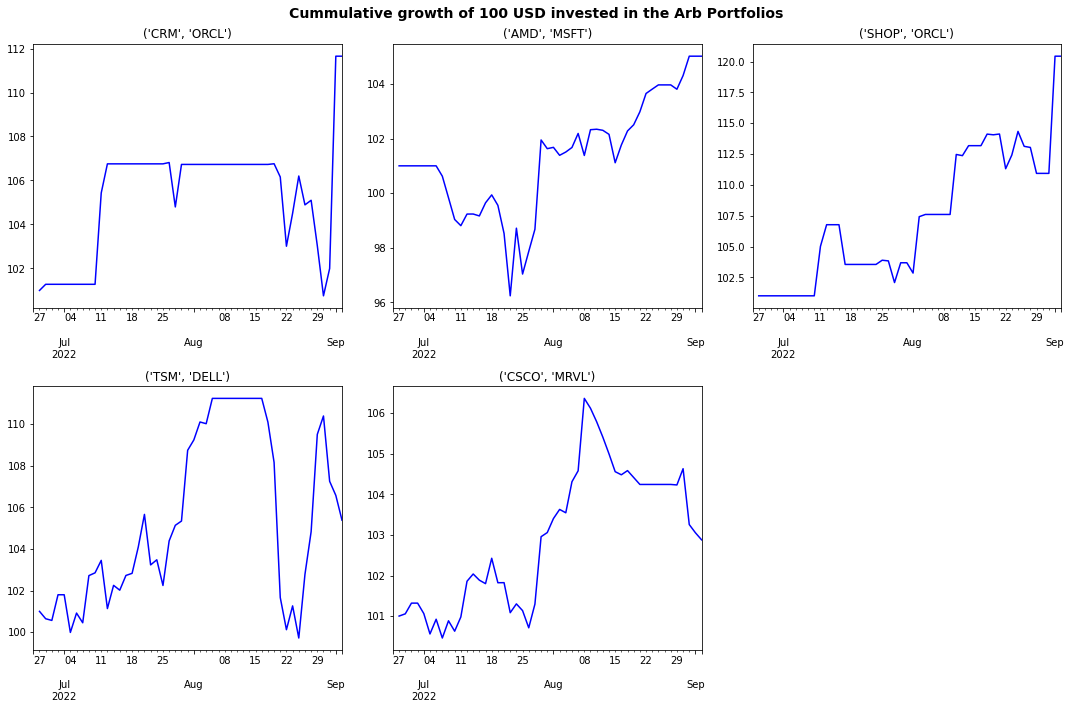

In [27]:

#Set initial invested amount:
arbitrage_returns.iloc[1] = 100
cummulative_growth = (arbitrage_returns + 1).cumprod()

fig,axs = plt.subplots(2, 3, figsize = (15, 10))
#Remove unused plot
fig.delaxes(axs[1,2])

axs = axs.flatten()

for i, column in enumerate(cummulative_growth.columns):
    ax = axs[i]
    cummulative_growth[column].plot(ax = ax, color="blue")
    ax.set_title(column)
    
fig.suptitle("Cummulative growth of 100 USD invested in the Arb Portfolios",
             fontweight = "bold", fontsize=14)
plt.tight_layout()
plt.show()
    